#Análise de sentimentos IMDB parte 1

Olá a todos,
Começarei uma série de artigos e códigos focados em Processamento de linguagem natural.

Aqui vocês verão:

- Extração de dados e limpeza
- Removendo dados nulos
- Removendo dados duplicados
-O que são StopWords e como remover elas do seu texto.
- Contrações dos verbos
- Lematização
- Word Clouds
- Exploração dos dados

Se você já leu algum dos meus outros artigos, talvez se lembre que eu tenho o hábito de ir explicando as coisas conforme vou fazendo, acho mais prático para todos.

Já adianto que será tudo muito simples e amador, por favor relevem as minhas faltas.

Estarei usando este conjunto de dados:

 https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

O que vamos fazer aqui?

Vamos fazer uma análise dos sentimentos deste conjunto de dados, em outras palavras vamos fazer uma análise exploratória padrão, mas focada nas palavras e fazer um levantamento das avaliações em si.

Este conjunto de dados se trata das avaliações que os usuários tiveram sobre vários filmes ao longo dos anos, ele contém duas colunas "reviews" (avaliações) onde estão os comentários de cada filme e a coluna "sentiment", onde os usuários colocaram "positivo" e "negativo" em relação aos filmes, a partir disso vamos trabalhar essas informações e depois ver elas em gráficos.

Vou deixar aqui as partes mais importantes do código, o restante vocês podem acessar o github e ver ele por completo:


# 1. Carregando as bibliotecas:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

import re,string,unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# 2. Extração de dados e limpeza:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving IMDB.csv to IMDB.csv


In [78]:
import io
data = pd.read_csv(io.BytesIO(uploaded['IMDB.csv']))
print('O tamanho do arquivo é:',data.shape)
data.head(2)

O tamanho do arquivo é: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [79]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [80]:
print(data.describe()) 

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


Dados Nulos:

In [81]:
# Descobrindo dados nulos:
null_values = data.isnull().sum()
print(null_values)

review       0
sentiment    0
dtype: int64


In [82]:
#Esse comando "recomaça" a contagem, se tirar ele o valor do próximo comando 
# será um, se colocar será outro.
null_values.index[0]

'review'

Dados duplicados:

In [83]:
num_duplicates = data.duplicated().sum()
print('Há {} avaliações duplicadas no df'.format(num_duplicates))

Há 418 avaliações duplicadas no df


In [84]:
# Carregando os dados duplicados:

# Colocamos dentro da variável "review" a coluna "reviwe"
review = data['review']

# o comando "isin" quer dizer "Está em?", ele confirma se há dados iguais.
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head(3)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative


In [85]:
# Deletando os dados duplicados:
data.drop_duplicates(inplace = True)

In [86]:
print('O dataset contêm {} linhas e {} colunas depois de remover os dados duplicados'.format(data.shape[0],data.shape[1]))

O dataset contêm 49582 linhas e 2 colunas depois de remover os dados duplicados


# StopWords

Stopword são palavras que NÃO trazem informações relevantes. As stopwords possuem uma frequência muito grande em todos os idiomas e por esse motivo precisamos eliminá-las do texto. Caso contrário, nosso algoritmo poderia dar importância para palavras como: “e”, “ou”, “para”….e isso atrapalharia nossa análise.


Os códigos abaixo poderão ser um pouco dificeis de se entender, eu mesmo achei uma parte dele já pronta e depois fui adaptando, testei muitas coisas e do jeito que está eu achei que ficou bom, talvez eu faça isso de outra forma futuramente, por hora eu explicarei o que acontece.

Antes de mais nada estaremos usando a biblioteca Natural Language toolkit (NLTK):
# https://www.nltk.org/

Dentro dela faremos o download das StopWords (as palavras que NÃO queremos)

Vocês verão (explicarei no código em si também) que primeiro eu eliminarei as StopWords, depois estarei pegando uma lista de contrações e aplicando no texto.

Vocês verão a célula onde estão as "Contractions", ou contrações, em portugues, o que é uma contração? Uma é:

* Contração com advérbio: de + aqui = daqui / de + aí = daí / de + ali = dali / de + onde =donde;
* Contração com pronome indefinido: de + outro(s) = doutro(s) / de + outra(s) = doutra(s)
* Contração da preposição “em” com artigo definido: em + o(s) = no(s) / em + a(s) = na(s)

E em inglês temos o mesmo:

* could’ve = could have

* he’d = he had or he would

* he’s = he is

Basicamente estamos deixando o texto mais legivel para o computador, ficará mais fácil de contabilizar as palavras, depois que as distinguirmos.

https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python



E ainda faremos uso da "Lematização" nas palavras, lematização (lemmatization) nada mais é do que fazer as palavras voltarem a sua forma básica, por exemplo: Andarei = Andar, Andemos = Andar, e por aí vai, assim teremos os verbos em si para contabilizar.

In [87]:
# Importamos a biblioteca nltk:
import nltk

# Aqui importamos o módulo stopwords (onde estão as stopwords
# damos a localização do arquivo para o computador poder fazer o download)
from nltk.corpus import stopwords

# Aqui fazemos o download das stopwords
nltk.download("stopwords")

# E finalmente colocamos dentro da varíavel stop as stopwords
stop = stopwords.words('english')

# Aqui nós colocamos o "lematizador" dentro do wl
wl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Como eu disse antes, aqui está a lista tirada da wikipédia, vamos usar ela e subtrair dos comentários (reviews).

In [89]:
contractions =  {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

# Limpando os arquivos

Aqui nós vamos tirar vários simbolos e coisas menores como pontos, virgulas, acentos e etc, que irão atrapalhar a analise, lembrem-se, nós queremos as palavras o mais "cru" possível, as palavras que ajudem o computador a chegar aos finalmentes.

**O código abaixo estaremos usando o BeautifulSoup, não sou especialista nesse pacote, tive de fazer algumas modificações aqui e ali nesse código para funcionar do jeito que eu queria, tenho certeza que existem formas melhores de se limpar o código.

In [90]:
# Aqui nós vamos criar o "clean_text" é aqui onde toda a mágica irá acontecer, depois iremos executar ele
# na coluna review alterando a coluna para o formato que nós queremos.

def clean_text(text,lemmatize = True):

    # Remove as tags do html
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Aqui nós aplicamos a lista de contrações (contractions) para fazer as palavras "descontracionarem?"
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # Aqui dizemos ao computador o que queremos que ele retire (simbolos e pontuações)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) 
    text = re.sub(r'http\S+', '', text)

    # Aqui, propriamente ele aplica o de cima e tira as pontuações.
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    
    # Basicamente, nós usamos a lematização aqui: wl.lemmatize(word) e depois colocamos espaços: text.split()
    # e o "word.isalpha" confirma que a palavra são apenas palavras sem simbolos ou números.
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else: # então
        # Se algumas dessas palavras não estiver na lista stop, então, coloque um espaço (.split()) e deixe ela somente
        # com palavras (isalpha())
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
        #Coloque tudo dentro do text
    return text

In [91]:
import nltk
nltk.download('wordnet')

# Como disse antes, vamos aplicar na coluna "review" que é onde está o nosso texto
# usando a função que criamos "clean_text" e ainda a outra função lemmatize.
data['review']=data['review'].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
#Aqui nós vamos pegar a coluna "sentiment" que é onde está os sentimentos
# "positive" e "negative" e nós iremos converter para 1 ou 0, isso irá melhorar bastante as nossas vidas.
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [93]:
#after converting labels
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


#3. Análise exploratória

Agora que já tratamos os dados, vamos ver como eles ficam em gráficos, uma análise simples.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


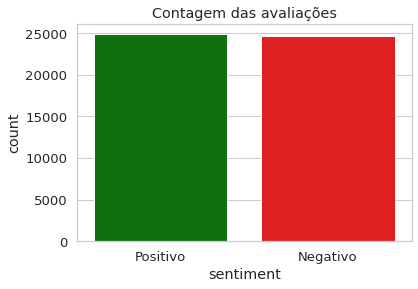

In [94]:
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['Positivo','Negativo'])
plt.title('Contagem das avaliações')
plt.show()

In [95]:
print('As avaliações Positivas são', (round(data['sentiment'].value_counts()[0])),'e em porcentagem é', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% do dataset')
print('As avaliações Negativas são', (round(data['sentiment'].value_counts()[1])),'e em porcentagem é',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% do dataset')

As avaliações Positivas são 24698 e em porcentagem é 49.81 % do dataset
As avaliações Negativas são 24884 e em porcentagem é 50.19 % do dataset


# Word Clouds

WordClouds é uma técnica de visualização de dados de texto onde cada palavra é retratada com sua importância no contexto ou sua frequência.

Deste modo vamos ver as palavras que mais aparecem.

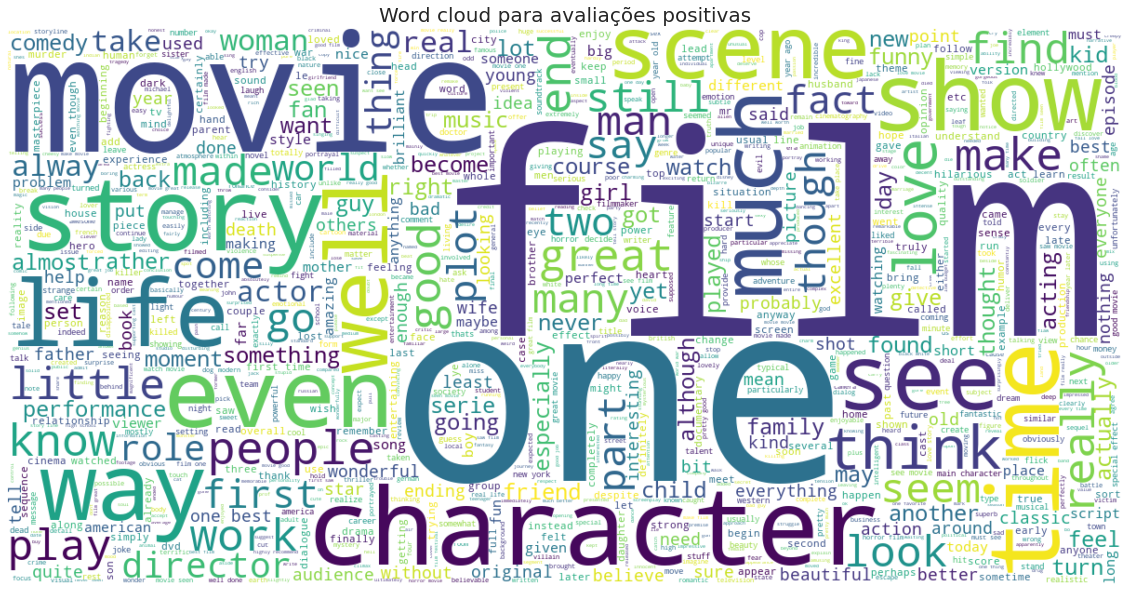

In [96]:
#lembram-se que eu mudei os positivos para 1 e os negativos para 0?
# Pois então, na linha abaixo, nós vamos jogar dentro de "positive_data"
# todos os números 1 da coluna sentiment (já modificada)
positive_data = data[data.sentiment == 1]['review']

positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud para avaliações positivas',fontsize = 20)
plt.show()

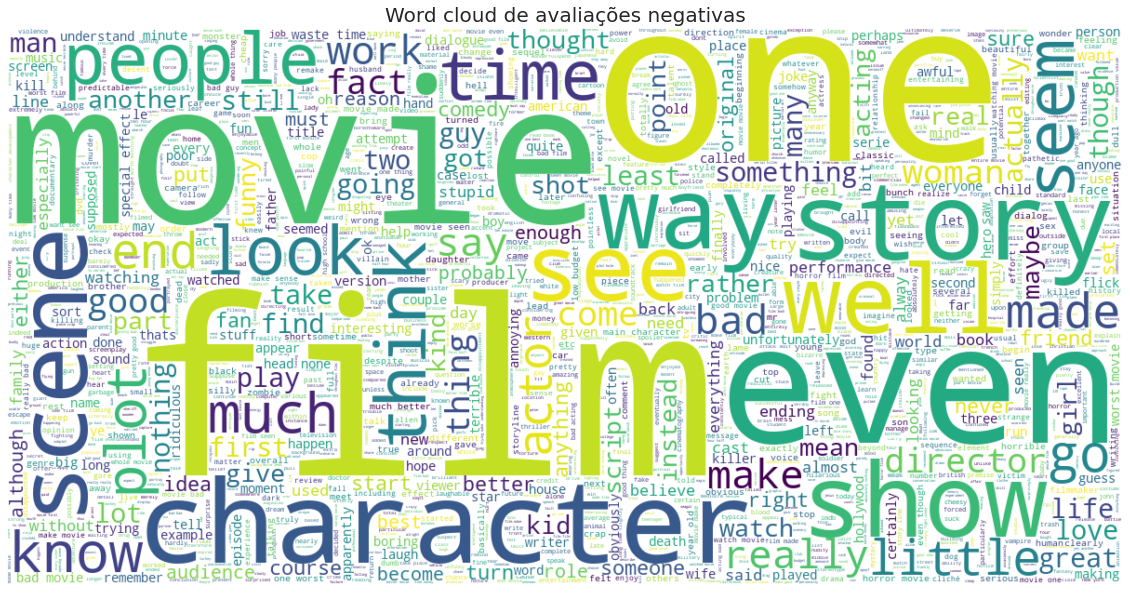

In [97]:
#E o que fizemos com o positivo acima, fazemos com o negativo também.
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud de avaliações negativas',fontsize = 20)
plt.show()

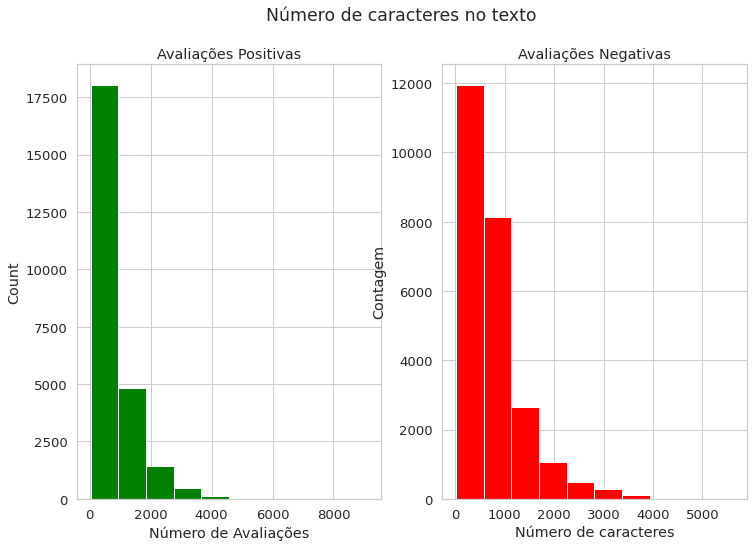

In [98]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Avaliações Positivas')
ax1.set_xlabel('Número de Avaliações')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Avaliações Negativas')
ax2.set_xlabel('Número de caracteres')
ax2.set_ylabel('Contagem')
fig.suptitle('Número de caracteres no texto')
plt.show()

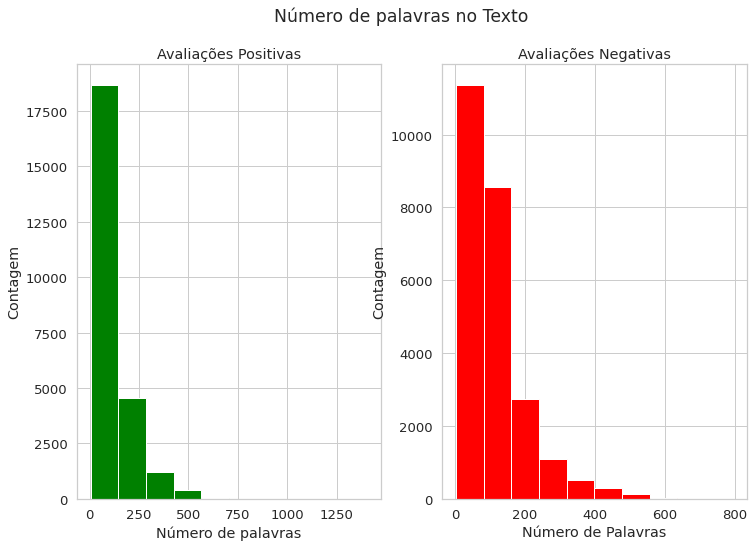

In [99]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Avaliações Positivas')
ax1.set_xlabel('Número de palavras')
ax1.set_ylabel('Contagem')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Avaliações Negativas')
ax2.set_xlabel('Número de Palavras')
ax2.set_ylabel('Contagem')
fig.suptitle('Número de palavras no Texto')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


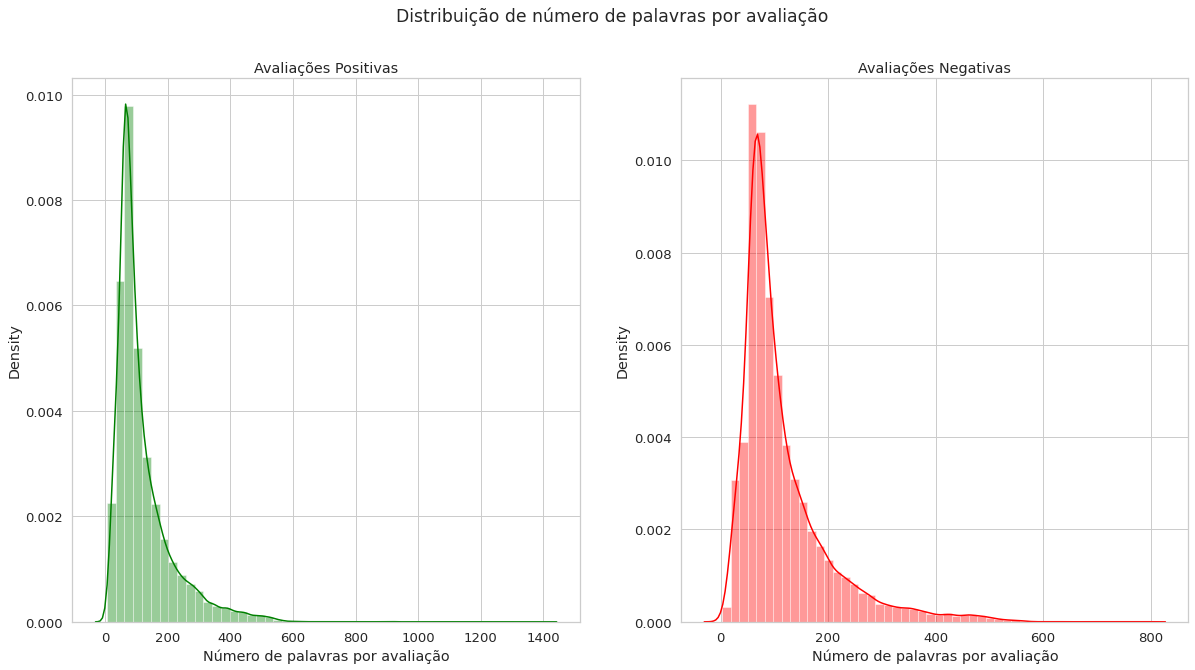

In [100]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Avaliações Positivas')
ax1.set_xlabel('Número de palavras por avaliação')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Avaliações Negativas')
ax2.set_xlabel('Número de palavras por avaliação')
fig.suptitle('Distribuição de número de palavras por avaliação')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


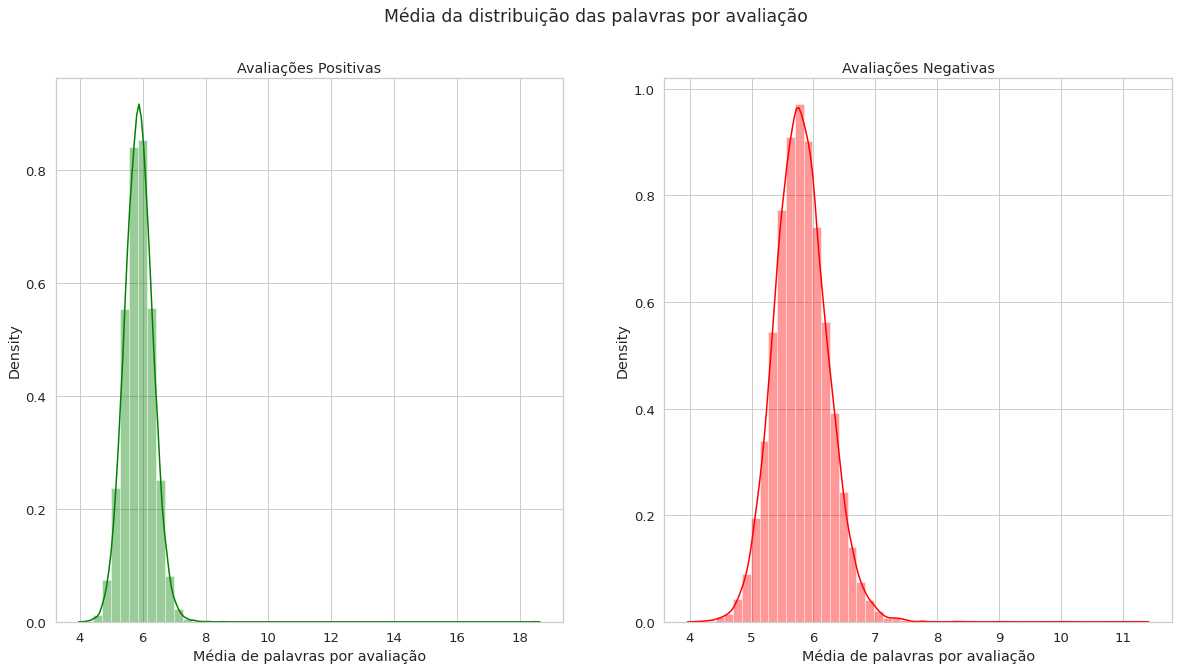

In [101]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Avaliações Positivas')
ax1.set_xlabel('Média de palavras por avaliação')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Avaliações Negativas')
ax2.set_xlabel('Média de palavras por avaliação')
fig.suptitle('Média da distribuição das palavras por avaliação')
plt.show()

In [102]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [103]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,100605
1,film,91130
2,one,53525
3,like,39746
4,time,30091
5,would,30037
6,good,28905
7,character,27801
8,story,24600
9,even,24440


In [104]:
# criamos a variável "most_common" e usamos o sort_values para deixar ele em ordem.
most_common = most_common.sort_values('countv')

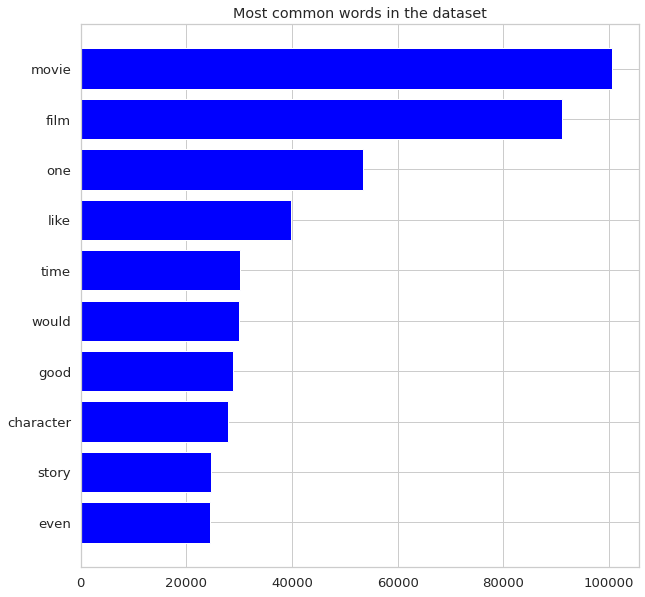

In [105]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [106]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)

    # Cria espaço na matriz "count_vector"
    bag_of_words = vec.transform(review)

    # Total de palavras
    sum_words = bag_of_words.sum(axis=0)

    # Converte para lista
    sum_words = np.array(sum_words)[0].tolist()

    # Pega a frequência de palavras dentro da variável "count_vector"
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]

    # A variável "key" é usada para classificar/ordenar sobre a variável "word_frequecy"
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

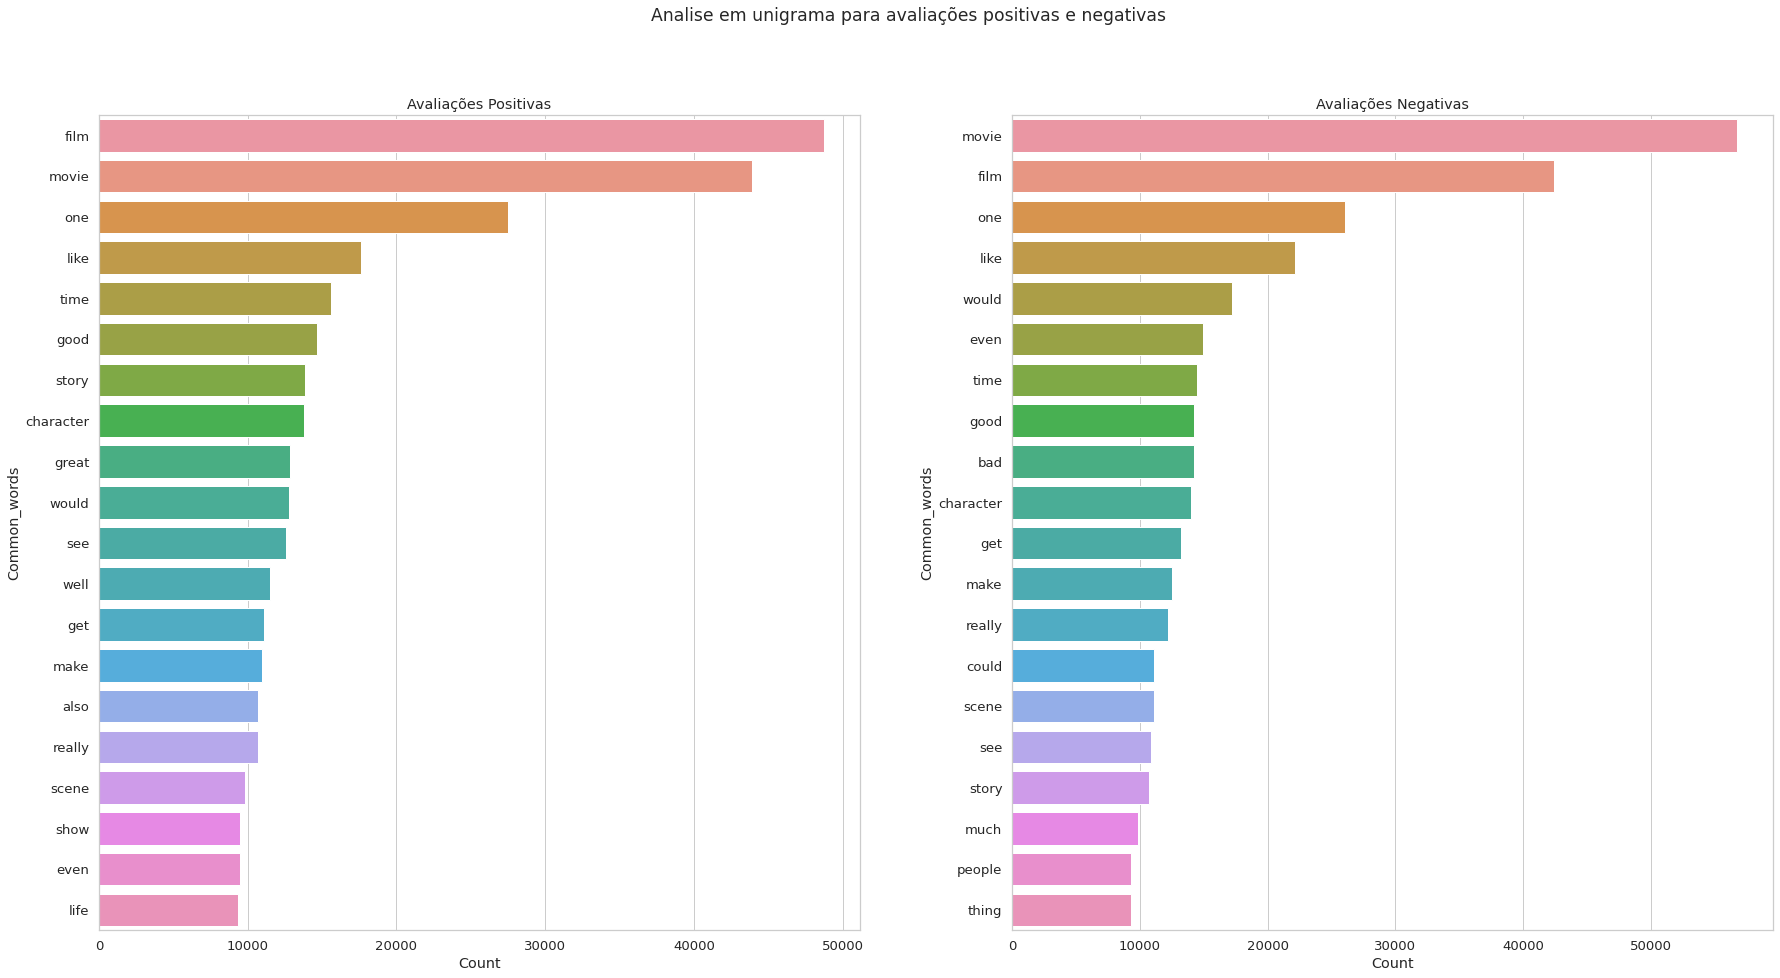

In [107]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Avaliações Positivas')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Avaliações Negativas')
fig.suptitle('Analise em unigrama para avaliações positivas e negativas')
plt.show()

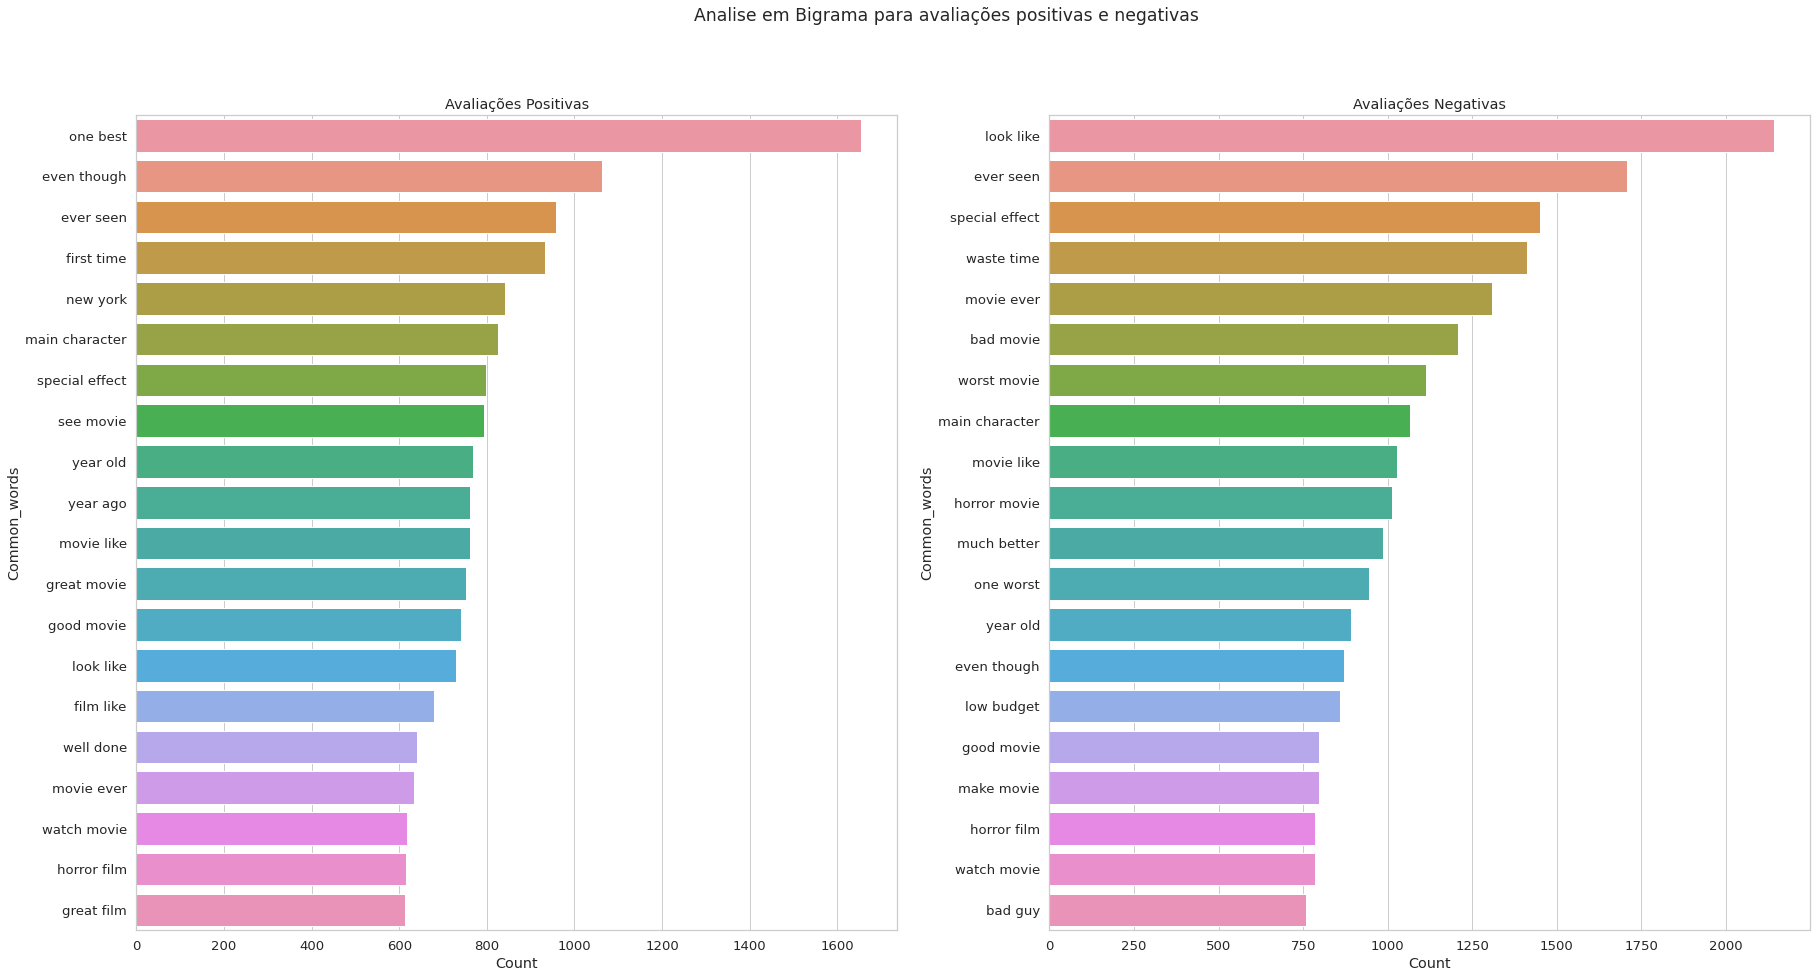

In [108]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Avaliações Positivas')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Avaliações Negativas')
fig.suptitle('Analise em Bigrama para avaliações positivas e negativas')
plt.show()

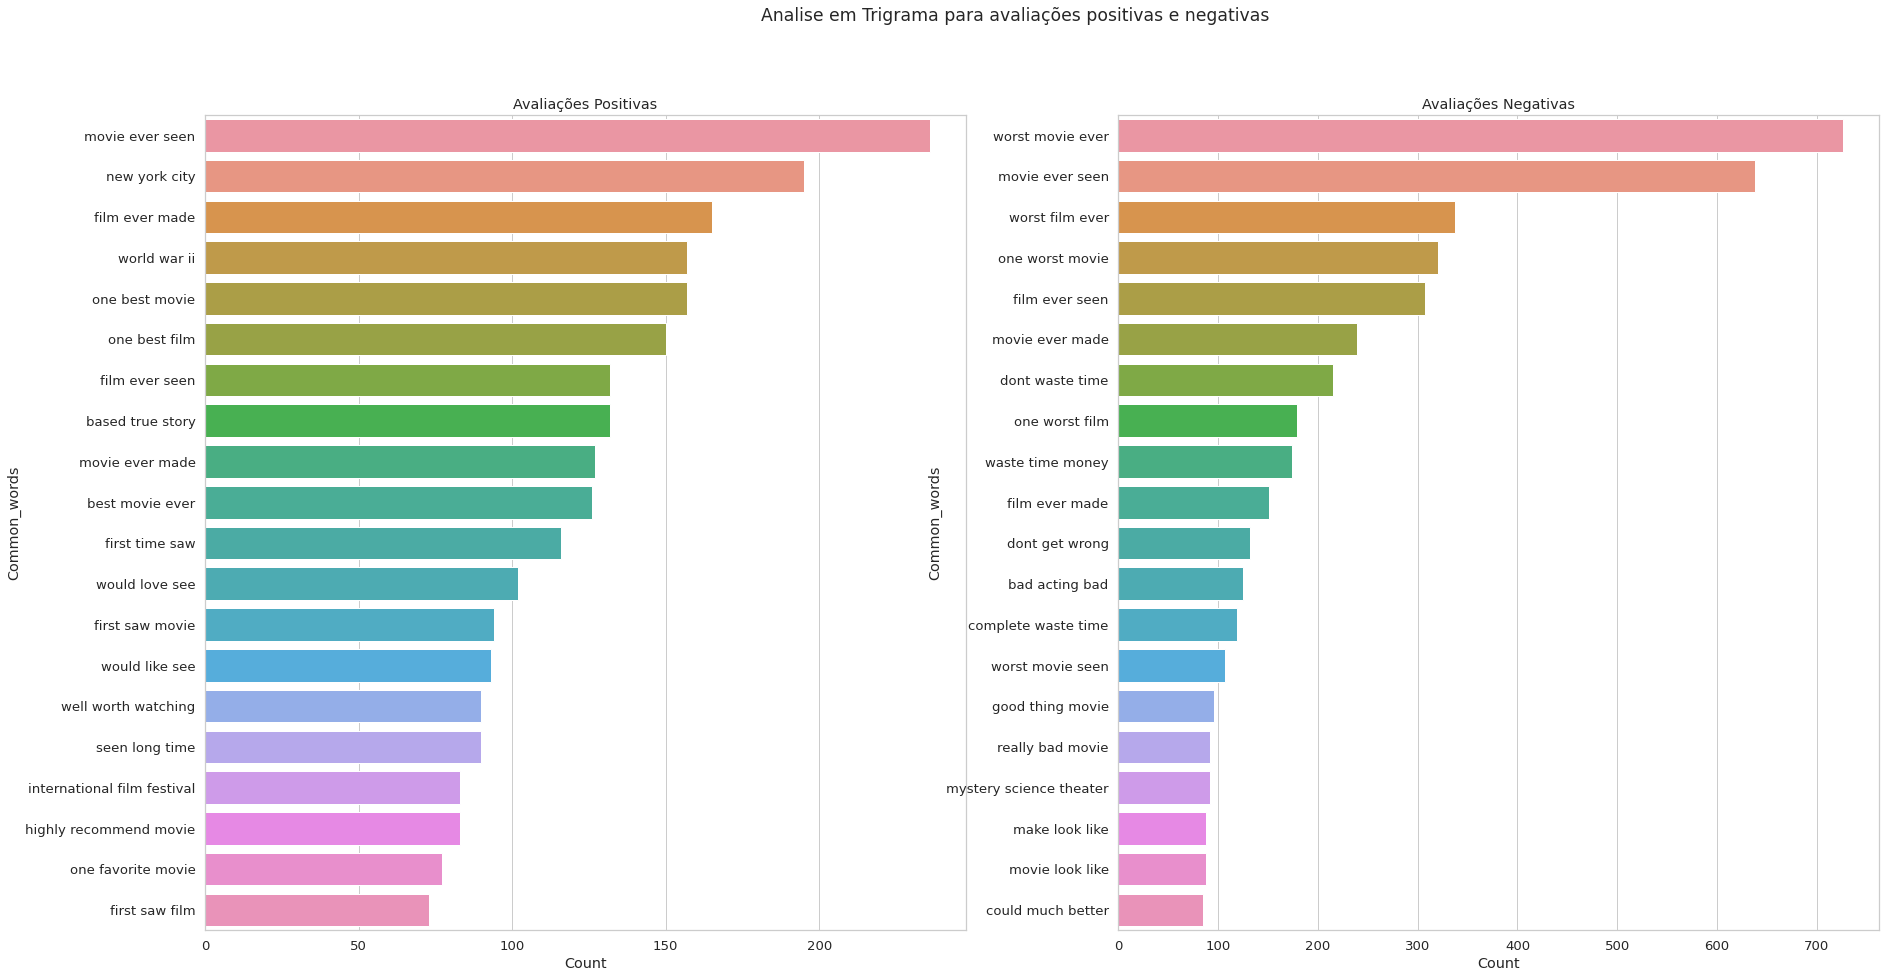

In [109]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Avaliações Positivas')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Avaliações Negativas')
fig.suptitle('Analise em Trigrama para avaliações positivas e negativas')
plt.show()